In [24]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import sklearn
from sklearn.datasets import make_checkerboard,make_circles,make_moons,make_s_curve,make_swiss_roll

In [25]:
def normalize(img):
    new_img = np.zeros(img.shape)
    if len(img.shape) == 3:
        for k in range(img.shape[2]):
            new_img[:, :, k] = normalize(img[:, :, k])

    else:
        new_img = (img - img.min()) / (img.max() - img.min())

    return new_img

In [26]:
def brute_forward_method(img, epochs , beta , generate_beta = True):
    
    '''
    Brute force forward diffusion.

    Parameters
    ----------
    img : numpy array
        Image to be diffused.

    epochs : int
        Number of epochs.

    beta: list
        List of beta values. Empty list incase generate_beta is True.
    
    generate_beta: bool
        If True, beta values are generated internally using cosine scheduling.

    Returns
    -------
    new_img : numpy array
        Diffused image.
    '''
    alph_t = 1
    
    if generate_beta:
        for i in range(epochs):
            beta = np.cos(i*np.pi/(1800*epochs))*0.1
            alpha = 1-beta
            img = np.sqrt(alpha)*img + np.sqrt(1-alpha)*np.random.normal(0, 1, img.shape)      
            alph_t *= alpha
    
    else:
        for b in beta:
            alpha = 1 - b
            img = np.sqrt(alpha)*img + np.sqrt(1-alpha)*np.random.normal(0, 1, img.shape)      
            alph_t *= alpha

    return img, alph_t

        

def optimal_forward_method(img, alpha_t):
    
    ''' 
    Analytical solution for the forward diffusion using the markov property

    Parameters
    ----------
    img : numpy array
        Image to be diffused.

    alpha_t : float
        The value of alpha at time t.

    Returns
    -------
    new_img : numpy array
        Diffused image.
    '''
    
    new_img = np.sqrt(alpha_t)*img + np.random.normal(0, (1-alpha_t), img.shape)
    return new_img

In [27]:
garden = plt.imread('garden.jpg')
dog = plt.imread('dog.jpg')
plane = plt.imread('plane.jpg')
apc = plt.imread('apc.jpg')

In [28]:
brut_garden, alpha1 = brute_forward_method(garden, 100 , beta = [] , generate_beta = True)
opt_garden = optimal_forward_method(garden, alpha1)
brut_dog, alpha2 = brute_forward_method(dog, 100 , beta = [] , generate_beta = True)
opt_dog = optimal_forward_method(dog, alpha2)

In [29]:
def make_beta_schedule(schedule='linear', n_timesteps=1000, start = 1e-4, end=0.2):
    if schedule == 'linear':
        betas = torch.linspace(start, end, n_timesteps)
    elif schedule == "quad":
        betas = torch.linspace(start ** 0.5, end ** 0.5, n_timesteps) ** 2
    elif schedule == "sigmoid":
        betas = torch.linspace(-6, 6, n_timesteps)
        betas = torch.sigmoid(betas) * (end - start) + start
    return betas

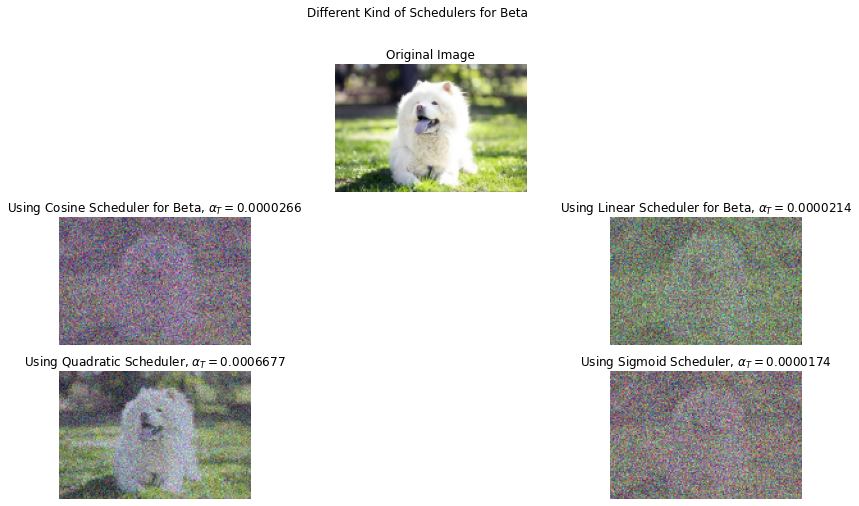

In [30]:
dog_c , a1 = brute_forward_method(dog, 100, generate_beta= True, beta = [])
dog_l , a2 = brute_forward_method(dog, 100, generate_beta= False, beta = make_beta_schedule(schedule='linear', n_timesteps=100).numpy())
dog_q , a3 = brute_forward_method(dog, 100, generate_beta= False, beta = make_beta_schedule(schedule='quad', n_timesteps=100).numpy())
dog_s , a4= brute_forward_method(dog, 100, generate_beta= False, beta = make_beta_schedule(schedule='sigmoid', n_timesteps=100).numpy())

plt.figure(figsize=(14, 8))
plt.subplot(3, 3, 2)
plt.title('Original Image')
plt.imshow(normalize(dog))
plt.axis('off')
plt.subplot(3, 3, 4)
plt.title('Using Cosine Scheduler for Beta, $\\alpha_T = ${:.7f}'.format(a1))
plt.imshow(normalize(dog_c))
plt.axis('off')
plt.subplot(3, 3, 6)
plt.title('Using Linear Scheduler for Beta, $\\alpha_T = ${:.7f}'.format(a2))
plt.imshow(normalize(dog_l))
plt.axis('off')
plt.subplot(3, 3, 7)
plt.title('Using Quadratic Scheduler, $\\alpha_T = ${:.7f}'.format(a3))
plt.imshow(normalize(dog_q))
plt.axis('off')
plt.subplot(3, 3, 9)
plt.title('Using Sigmoid Scheduler, $\\alpha_T = ${:.7f}'.format(a4))
plt.imshow(normalize(dog_s))
plt.axis('off')
plt.suptitle('Different Kind of Schedulers for Beta')
plt.show()

**Binarizing the images to work with**

In [31]:
def grayscale(img):
    return np.dot(img[...,:3], [0.299, 0.587, 0.114])

def histogram(img):
    # a basic function to get the histogram of an image
    if np.max(img) == 1:
        img = np.array(img*255, dtype = int)
    
    hist = np.zeros(256, dtype=int)
    
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            hist[img[i, j]] += 1
    
    return hist

def normalised_hist(img):
    # function to get the normalised histogram of an image

    hist = histogram(img)
    hist = hist/(img.shape[0]*img.shape[1])
    return hist

def otsu_thresh(img):
    '''
    Uses the more efficient implementation of the actual Otsu's Algorithm.

    Input: A grayscale image
           (2-D Numpy Array)

    Output: The threshold value
            (Integer)
    '''
    hist = normalised_hist(img)                                 # getting the normalized histogram for the calculation of p_0
    max_var = 0
    thresh = 0
    p0_ = hist[0]
    mu0 = 0
    
    for i in range(1, 255):
        p0 = p0_ + hist[i]
        
        if p0 == 0:
            continue                                            # if p0 is 0, then the value of mu0 will be 0, so we can skip this iteration
        if p0 == 1:
            break                                               # if p0 is 1, then the value of mu1 will be 0, so we can skip the rest of the iterations
        
        mu0 = (mu0*p0_ + i*hist[i])/p0
        mu1 = (np.mean(img) - p0*mu0)/(1 - p0)
        var = p0*(1 - p0)*(mu0 - mu1)**2
        
        if var > max_var:
            max_var = var                                       # updating the maximum variance
            thresh = i
        
        p0_ = p0
    
    return thresh

def binarize_thresh(img, thresh):
    ''' 
    Function to binarize an image given a threshold value

    Input: img: A grayscale image (2D numpy array)
           thresh: A threshold value (integer)

    Output: A binarized image (2D numpy array)
    '''
    new = np.zeros(img.shape, dtype=np.uint8)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            
            if img[i, j] > thresh:                      # checking the pixel value with the input threshold
                new[i, j] = 255
            else:
                new[i, j] = 0
    
    return new

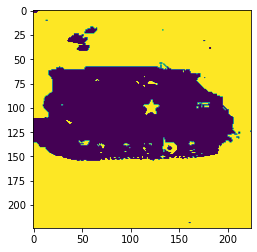

In [32]:
gray_apc = grayscale(apc)
gray_apc = np.array(normalize(gray_apc)*255, dtype = int)
t = otsu_thresh(gray_apc)
bin_apc = binarize_thresh(gray_apc, t)
data = np.array(np.where(bin_apc == 0), dtype=float)
normalised_data = []
normalised_data.append(np.array((data[0] - np.mean(data[0]))/(np.max(data[0]) - np.min(data[0]))))
normalised_data.append(np.array((data[1] - np.mean(data[1]))/(np.max(data[1]) - np.min(data[1]))))
normalised_data = np.array(normalised_data)

plt.imshow(bin_apc)
plt.show()

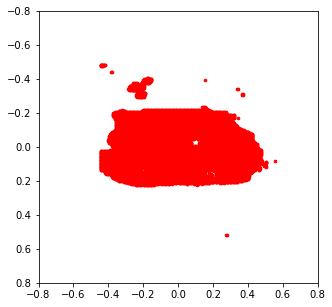

In [33]:
plt.figure(figsize=(5, 5))
plt.scatter(normalised_data[1], normalised_data[0], s = 7, c = 'r')
plt.gca().invert_yaxis()
plt.xlim(-0.8, 0.8)
plt.ylim(0.8, -0.8)
plt.show()

In [34]:
dataset = torch.tensor(normalised_data.T, dtype=torch.float32)
dataset.shape

torch.Size([16603, 2])

(-1.5233537800840575,
 2.4910573474045616,
 -0.9046735754173969,
 1.3735103849299608)

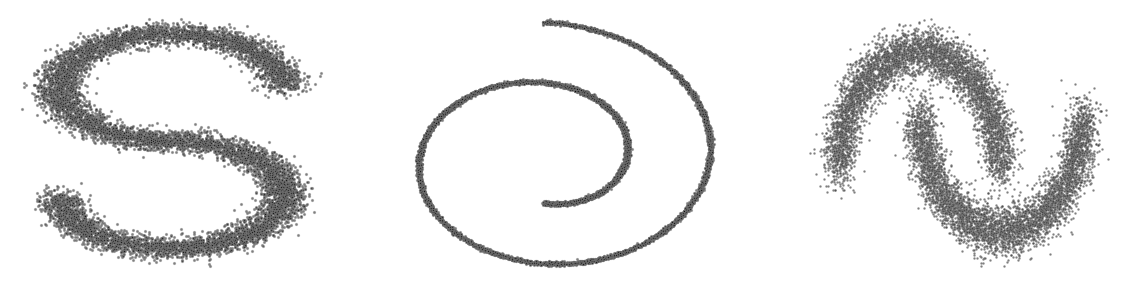

In [35]:
%matplotlib inline

swiss_roll, _ = make_swiss_roll(10**4,noise=0.1)
swiss_roll = swiss_roll[:, [0, 2]]/10.0

s_curve, _ = make_s_curve(10**4, noise=0.1)
s_curve = s_curve[:, [0, 2]]/10.0

moons, _ = make_moons(10**4, noise=0.1)

data = s_curve.T
#dataset = torch.Tensor(data.T).float()


fig,axes = plt.subplots(1,3,figsize=(20,5))

axes[0].scatter(*data, alpha=0.5, color='black', edgecolor='gray', s=5);
axes[0].axis('off')

data = swiss_roll.T
axes[1].scatter(*data, alpha=0.5, color='black', edgecolor='gray', s=5);
axes[1].axis('off')
dataset = torch.Tensor(data.T).float()

data = moons.T
axes[2].scatter(*data, alpha=0.5, color='black', edgecolor='gray', s=3);
axes[2].axis('off')
# dataset = torch.Tensor(data.T).float()

In [36]:
dataset = torch.tensor(normalised_data.T, dtype=torch.float32)
dataset.shape

torch.Size([16603, 2])

In [37]:
# Loss Function for Diffusion Model
# Original Source: https://github.com/acids-ircam/diffusion_models

def extract(input, t, x):
    shape = x.shape
    out = torch.gather(input, 0, t.to(input.device))
    reshape = [t.shape[0]] + [1] * (len(shape) - 1)
    return out.reshape(*reshape)

def q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var

def p_mean_variance(model, x, t):
    # Go through model
    out = model(x, t)
    # Extract the mean and variance
    mean, log_var = torch.split(out, 2, dim=-1)
    var = torch.exp(log_var)
    return mean, log_var

def p_sample(model, x, t,alphas,betas,one_minus_alphas_bar_sqrt):
    t = torch.tensor([t])
    # Factor to the model output
    eps_factor = ((1 - extract(alphas, t, x)) / extract(one_minus_alphas_bar_sqrt, t, x))
    # Model output
    eps_theta = model(x, t)
    # Final values
    mean = (1 / extract(alphas, t, x).sqrt()) * (x - (eps_factor * eps_theta))
    # Generate z
    z = torch.randn_like(x)
    # Fixed sigma
    sigma_t = extract(betas, t, x).sqrt()
    sample = mean + sigma_t * z
    return (sample)

def p_sample_loop(model, shape,n_steps,alphas,betas,one_minus_alphas_bar_sqrt):
    cur_x = torch.randn(shape)
    x_seq = [cur_x]
    for i in reversed(range(n_steps)):
        cur_x = p_sample(model, cur_x, i,alphas,betas,one_minus_alphas_bar_sqrt)
        x_seq.append(cur_x)
    return x_seq

def approx_standard_normal_cdf(x):
    return 0.5 * (1.0 + torch.tanh(torch.tensor(np.sqrt(2.0 / np.pi)) * (x + 0.044715 * torch.pow(x, 3))))

def discretized_gaussian_log_likelihood(x, means, log_scales):
    # Assumes data is integers [0, 255] rescaled to [-1, 1]
    centered_x = x - means
    inv_stdv = torch.exp(-log_scales)
    plus_in = inv_stdv * (centered_x + 1. / 255.)
    cdf_plus = approx_standard_normal_cdf(plus_in)
    min_in = inv_stdv * (centered_x - 1. / 255.)
    cdf_min = approx_standard_normal_cdf(min_in)
    log_cdf_plus = torch.log(torch.clamp(cdf_plus, min=1e-12))
    log_one_minus_cdf_min = torch.log(torch.clamp(1 - cdf_min, min=1e-12))
    cdf_delta = cdf_plus - cdf_min
    log_probs = torch.where(x < -0.999, log_cdf_plus, torch.where(x > 0.999, log_one_minus_cdf_min, torch.log(torch.clamp(cdf_delta, min=1e-12))))
    return log_probs

def normal_kl(mean1, logvar1, mean2, logvar2):
    kl = 0.5 * (-1.0 + logvar2 - logvar1 + torch.exp(logvar1 - logvar2) + ((mean1 - mean2) ** 2) * torch.exp(-logvar2))
    return kl

def q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt ,noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

def loss_variational(model, x_0,alphas_bar_sqrt, one_minus_alphas_bar_sqrt,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # Perform diffusion for step t
    x_t = q_sample(x_0, t, alphas_bar_sqrt, one_minus_alphas_bar_sqrt)
    # Compute the true mean and variance
    true_mean, true_var = q_posterior_mean_variance(x_0, x_t, t,posterior_mean_coef_1,posterior_mean_coef_2,posterior_log_variance_clipped)
    # Infer the mean and variance with our model
    model_mean, model_var = p_mean_variance(model, x_t, t)
    # Compute the KL loss
    kl = normal_kl(true_mean, true_var, model_mean, model_var)
    kl = torch.mean(kl.view(batch_size, -1), dim=1) / np.log(2.)
    # NLL of the decoder
    decoder_nll = -discretized_gaussian_log_likelihood(x_0, means=model_mean, log_scales=0.5 * model_var)
    decoder_nll = torch.mean(decoder_nll.view(batch_size, -1), dim=1) / np.log(2.)
    # At the first timestep return the decoder NLL, otherwise return KL(q(x_{t-1}|x_t,x_0) || p(x_{t-1}|x_t))
    output = torch.where(t == 0, decoder_nll, kl)
    return output.mean(-1)

In [38]:
def noise_estimation_loss(model, x_0,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,n_steps):
    batch_size = x_0.shape[0]
    # Select a random step for each example
    t = torch.randint(0, n_steps, size=(batch_size // 2 + 1,))
    t = torch.cat([t, n_steps - t - 1], dim=0)[:batch_size].long()
    # x0 multiplier
    a = extract(alphas_bar_sqrt, t, x_0)
    # eps multiplier
    am1 = extract(one_minus_alphas_bar_sqrt, t, x_0)
    e = torch.randn_like(x_0)
    # model input
    x = x_0 * a + e * am1
    output = model(x, t)
    return (e - output).square().mean()

In [39]:
num_steps = 100

betas = make_beta_schedule(schedule='sigmoid', n_timesteps=num_steps, start=1e-5, end=0.5e-2)

alphas = 1 - betas
alphas_prod = torch.cumprod(alphas, 0)
alphas_prod_p = torch.cat([torch.tensor([1]).float(), alphas_prod[:-1]], 0)
alphas_bar_sqrt = torch.sqrt(alphas_prod)
one_minus_alphas_bar_log = torch.log(1 - alphas_prod)
one_minus_alphas_bar_sqrt = torch.sqrt(1 - alphas_prod)

In [40]:
def q_x(x_0, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_0)
    alphas_t = extract(alphas_bar_sqrt, t, x_0)
    alphas_1_m_t = extract(one_minus_alphas_bar_sqrt, t, x_0)
    return (alphas_t * x_0 + alphas_1_m_t * noise)

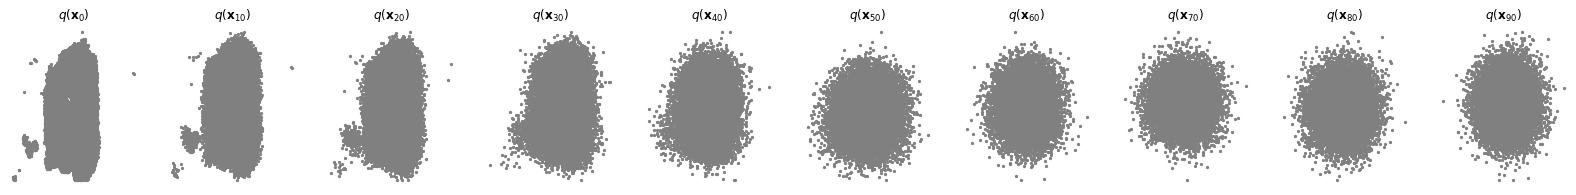

In [41]:
fig, axs = plt.subplots(1, 10, figsize=(28, 3))
for i in range(10):
    q_i = q_x(dataset, torch.tensor([i * 10]))
    axs[i].scatter(q_i[:, 0], q_i[:, 1],color='gray', s=5);
    axs[i].set_axis_off(); axs[i].set_title('$q(\mathbf{x}_{'+str(i*10)+'})$')

In [42]:
posterior_mean_coef_1 = (betas * torch.sqrt(alphas_prod_p) / (1 - alphas_prod))
posterior_mean_coef_2 = ((1 - alphas_prod_p) * torch.sqrt(alphas) / (1 - alphas_prod))
posterior_variance = betas * (1 - alphas_prod_p) / (1 - alphas_prod)
posterior_log_variance_clipped = torch.log(torch.cat((posterior_variance[1].view(1, 1), posterior_variance[1:].view(-1, 1)), 0)).view(-1)

def q_posterior_mean_variance(x_0, x_t, t):
    coef_1 = extract(posterior_mean_coef_1, t, x_0)
    coef_2 = extract(posterior_mean_coef_2, t, x_0)
    mean = coef_1 * x_0 + coef_2 * x_t
    var = extract(posterior_log_variance_clipped, t, x_0)
    return mean, var
    

In [43]:
#An Implementation of Diffusion Network Model
#Oringinal source: https://github.com/acids-ircam/diffusion_models

import torch.nn as nn
import torch.nn.functional as F

class ConditionalLinear(nn.Module):
    def __init__(self, num_in, num_out, n_steps):
        super(ConditionalLinear, self).__init__()
        self.num_out = num_out
        self.lin = nn.Linear(num_in, num_out)
        self.embed = nn.Embedding(n_steps, num_out)
        self.embed.weight.data.uniform_()

    def forward(self, x, y):
        out = self.lin(x)
        gamma = self.embed(y)
        out = gamma.view(-1, self.num_out) * out
        return out
        
class ConditionalModel(nn.Module):
    def __init__(self, n_steps):
        super(ConditionalModel, self).__init__()
        self.lin1 = ConditionalLinear(2, 128, n_steps)
        self.lin2 = ConditionalLinear(128, 128, n_steps)
        self.lin3 = ConditionalLinear(128, 128, n_steps)
        self.lin4 = nn.Linear(128, 2)
    
    def forward(self, x, y):
        x = F.softplus(self.lin1(x, y))
        x = F.softplus(self.lin2(x, y))
        x = F.softplus(self.lin3(x, y))
        return self.lin4(x)



In [45]:
import torch.optim as optim

model = ConditionalModel(num_steps)
optimizer = optim.Adam(model.parameters(), lr=1e-2)

tensor(0.7533, grad_fn=<MeanBackward0>)


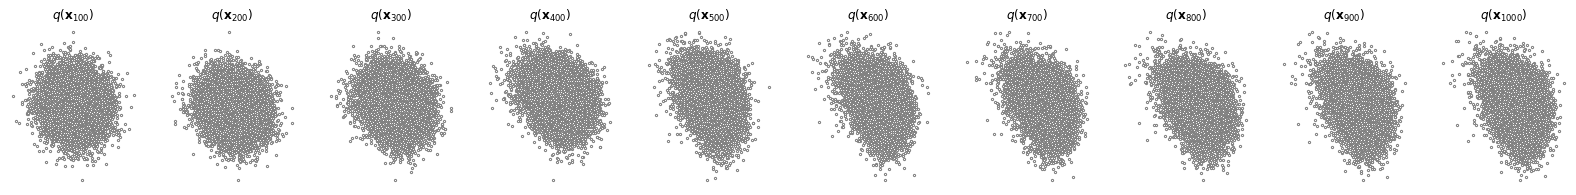

tensor(0.5511, grad_fn=<MeanBackward0>)


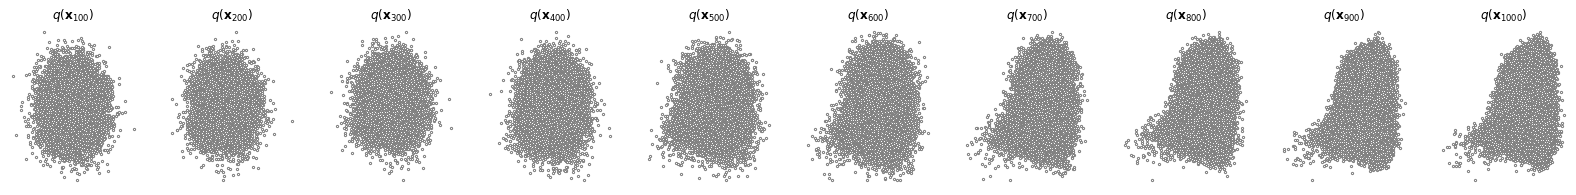

In [46]:

# Batch size
batch_size = 128
for t in range(500):
    # X is a torch Variable
    permutation = torch.randperm(dataset.size()[0])
    for i in range(0, dataset.size()[0], batch_size):
        # Retrieve current batch
        indices = permutation[i:i+batch_size]
        batch_x = dataset[indices]
        # Compute the loss.
        loss = noise_estimation_loss(model, batch_x,alphas_bar_sqrt,one_minus_alphas_bar_sqrt,num_steps)
        # Before the backward pass, zero all of the network gradients
        optimizer.zero_grad()
        # Backward pass: compute gradient of the loss with respect to parameters
        loss.backward()
        # Perform gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.)
        # Calling the step function to update the parameters
        optimizer.step()

    # Print loss
    if (t % 100 == 0):
        print(loss)
        x_seq = p_sample_loop(model, dataset.shape,num_steps,alphas,betas,one_minus_alphas_bar_sqrt)
        fig, axs = plt.subplots(1, 10, figsize=(28, 3))
        for i in range(1, 11):
            cur_x = x_seq[i * 10].detach()
            axs[i-1].scatter(cur_x[:, 0], cur_x[:, 1],color='white',edgecolor='gray', s=5);
            axs[i-1].set_axis_off(); 
            axs[i-1].set_title('$q(\mathbf{x}_{'+str(i*100)+'})$')
        plt.show()